In [14]:
import numpy as np
import EOBRun_module
from pycbc.types import timeseries
import matplotlib.pyplot as plt
from calcwf import chirp2total

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [4]:
def gen_teob_wf(f, e, M, q, sample_rate, phase, distance, TA, inclination, freq_type, modes):

    # Gets appropriate frequency quantity
    if freq_type == 'average':
        f_avg = f_kep2avg(f, e)
        freq_type_id = 1
    elif freq_type == 'orbitaveraged':
        f_avg = f
        freq_type_id = 3
    else:
        raise Exception('freq_type not recognised')

    # Define parameters
    k = modes_to_k(modes)
    print(modes, k)
    pars = {
            'M'                  : M,
            'q'                  : q,    
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 'no',         # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 'no',         # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_avg,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 'yes',        # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : distance,
            'coalescence_angle'  : phase,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 'no',
            'ecc_freq'           : freq_type_id,
            'anomaly'            : TA,
            'inclination'        : inclination
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p, teob_c

In [5]:
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

for i in range(0,6):
    for j in range(0, i+1):
        print(f'({i}, {j}): {modes_to_k([[i,j]])}')

(0, 0): [-2]
(1, 0): [-2]
(1, 1): [-1]
(2, 0): [-1]
(2, 1): [0]
(2, 2): [1]
(3, 0): [1]
(3, 1): [2]
(3, 2): [3]
(3, 3): [4]
(4, 0): [4]
(4, 1): [5]
(4, 2): [6]
(4, 3): [7]
(4, 4): [8]
(5, 0): [8]
(5, 1): [9]
(5, 2): [10]
(5, 3): [11]
(5, 4): [12]
(5, 5): [13]


It is very puzzling here why the modes [i,i] and [i+1,0] correspond to the same value of k.

The A_n term in e.g. https://arxiv.org/pdf/astro-ph/0111107 should only show up when inclination is non-zero. Additionally it should only show up in [2,0], [2,1] modes rather than the [2,2] mode we have been using so far.

[[2, 2]] [1]
[[2, 1], [2, 2]] [0, 1]
[[2, 0], [2, 1], [2, 2]] [-1, 0, 1]


(-6.0, -5.0)

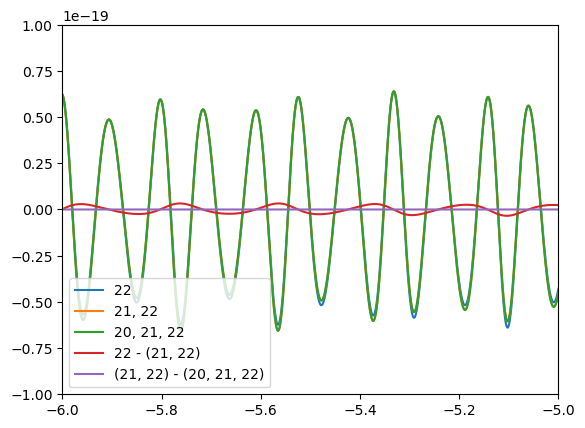

In [13]:
h_22 = gen_teob_wf(10, 0.1, 60, 2, 4096, 0, 1, np.pi, np.pi/2, 'orbitaveraged', [[2,2]])
h_22 = h_22[0] - 1j*h_22[1]
h_2122 = gen_teob_wf(10, 0.1, 60, 2, 4096, 0, 1, np.pi, np.pi/2, 'orbitaveraged', [[2,1], [2,2]])
h_2122 = h_2122[0] - 1j*h_2122[1]
h_2122.start_time = h_22.start_time
h_202122 = gen_teob_wf(10, 0.1, 60, 2, 4096, 0, 1, np.pi, np.pi/2, 'orbitaveraged', [[2,0], [2,1], [2,2]])
h_202122 = h_202122[0] - 1j*h_202122[1]
h_202122.start_time = h_22.start_time

plt.plot(h_22.sample_times, h_22.real(), label='22')
plt.plot(h_2122.sample_times, h_2122.real(), label='21, 22')
plt.plot(h_202122.sample_times, h_202122.real(), label='20, 21, 22')
plt.plot((h_22-h_2122).sample_times, (h_22-h_2122).real(), label='22 - (21, 22)')
plt.plot((h_2122-h_202122).sample_times, (h_2122-h_202122).real(), label = '(21, 22) - (20, 21, 22)')
plt.legend()
plt.ylim(-1e-19,1e-19)
plt.xlim(-6,-5)

It seems that the (2,0) mode here is zero, however generating this mode by itself fails so this should not be trusted.

Let's check that the (2,1) mode found by difference of waveforms above is the same as that found from generating just the (2,1) mode.

[[2, 1]] [0]


(-6.0, -5.0)

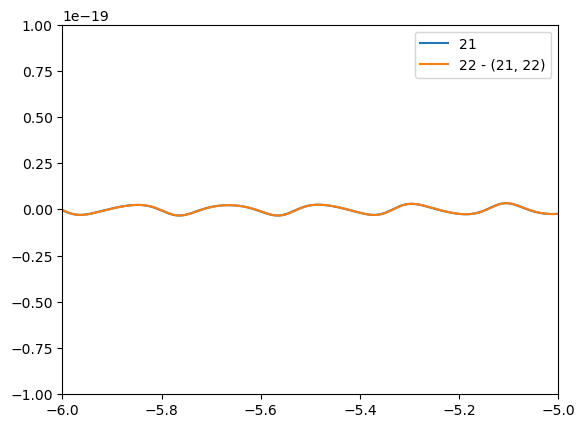

In [10]:
h_21 = gen_teob_wf(10, 0.1, 60, 2, 4096, 0, 1, np.pi, np.pi/2, 'orbitaveraged', [[2,1]])
h_21 = h_21[0] - 1j*h_21[1]

plt.plot(h_21.sample_times, h_21.real(), label='21')
plt.plot((h_22-h_2122).sample_times, -(h_22-h_2122).real(), label='22 - (21, 22)')
plt.legend()
plt.ylim(-1e-19,1e-19)
plt.xlim(-6,-5)

If this is (purely) the missing A_n term then we would expect the frequenc(ies) to be multiples of the radial frequency.

In [18]:
h_22 = gen_teob_wf(5, 0.2, chirp2total(10, 2), 2, 4096, 0, 1, np.pi, np.pi/2, 'orbitaveraged', [[2,2]])
h_22 = h_22[0] - 1j*h_22[1]
h_22f = h_22[:8*4096].real().to_frequencyseries()

h_21 = gen_teob_wf(5, 0.2, chirp2total(10, 2), 2, 4096, 0, 1, np.pi, np.pi/2, 'orbitaveraged', [[2,1]])
h_21 = h_21[0] - 1j*h_21[1]
h_21f = h_21[:8*4096].real().to_frequencyseries()

[[2, 2]] [1]
[[2, 1]] [0]


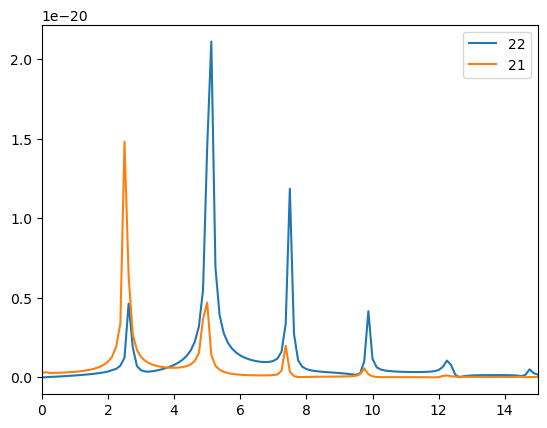

In [20]:
plt.plot(h_22f.sample_frequencies, np.abs(h_22f), label='22')
plt.plot(h_21f.sample_frequencies, 20*np.abs(h_21f), label='21')
plt.xlim(0, 15)
plt.legend()

See here that the frequencies in 21 of $(k+2) \times$ (azimuthal) are all slightly lower than that of 22 which contains the frequencies of $2\times$(azimuthal) + $k\times$(radial). This is consistent as the azimuthal frequency is slightly lower than the radial frequency.

Note that I have multiplied the power in 21 by a factor of 20 in order to compare them on the same scale. In reality the 21 mode is very subdominant.